# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
# 1. 参数设置
max_degree = 20 # 生成最高20阶的多项式特征
n_train, n_test = 100, 100 # 训练集和测试集各100个样本
true_w = np.zeros(max_degree) # 真实权重向量，长度20。
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 前4个非零系数对应一个3次多项式
# 2. 生成原始特征
    # n_train + n_test：总行数（样本总数），100个训练样本+100个测试样本
    # 1：总列数（特征维度），表示每个样本只有1个特征
features = np.random.normal(size=(n_train + n_test, 1)) # 生成200个服从标准正态分布的随机数作为输入特征x
np.random.shuffle(features) # 打乱顺序确保训练/测试集分布一致
'''
3. 生成多项式特征
将每个x计算 0~19 次幂，生成形状为 (200, 20) 的特征矩阵
第i列对应x_{i}
'''
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# 4. 除以阶乘（泰勒级数形式）：每列除以对应的阶乘Γ(i+1)=i!，避免高阶项数值过大
for i in range(max_degree):
    # : ：冒号表示选取所有行（即所有样本）i ：选取第i列（从0开始计数）
    # 具体含义：poly_features[:, i] 提取出所有样本的第i个特征，返回一个形状为(200,)的一维数组
    poly_features[:, i] /= math.gamma(i + 1)
# 5. 生成标签并加噪声
labels = np.dot(poly_features, true_w) # 通过矩阵乘法计算真实标签（基于3次多项式）
labels += np.random.normal(scale=0.1, size=labels.shape) # 添加标准差为 0.1 的高斯噪声，模拟真实数据

查看一下前2个样本

In [3]:
'''
true_w：真实权重向量（形状 max_degree）
features：原始特征（形状 (200, 1)）
poly_features：多项式特征矩阵（形状 (200, max_degree)）
labels：标签向量（形状 (200,)）
'''
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
'''
features[:2]：前2个样本的原始特征(2,1)
poly_features[:2,:]：前2个样本的所有多项式特征(2,max_degree)
labels[:2]：前2个样本的标签	(2,)
'''
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.8418],
         [0.0371]]),
 tensor([[1.0000e+00, 8.4180e-01, 3.5431e-01, 9.9419e-02, 2.0923e-02, 3.5225e-03,
          4.9420e-04, 5.9431e-05, 6.2536e-06, 5.8492e-07, 4.9238e-08, 3.7680e-09,
          2.6433e-10, 1.7116e-11, 1.0292e-12, 5.7756e-14, 3.0387e-15, 1.5047e-16,
          7.0368e-18, 3.1177e-19],
         [1.0000e+00, 3.7095e-02, 6.8800e-04, 8.5071e-06, 7.8892e-08, 5.8529e-10,
          3.6185e-12, 1.9175e-14, 8.8912e-17, 3.6646e-19, 1.3594e-21, 4.5841e-24,
          1.4171e-26, 4.0435e-29, 1.0714e-31, 2.6495e-34, 6.1425e-37, 1.3403e-39,
          2.7620e-42, 5.6052e-45]]),
 tensor([5.3080, 5.0331]))

实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    # 创建一个累加器，用于累加两个数值：metric[0]：存储总损失值；metric[1]：存储总样本数
    metric = d2l.Accumulator(2)
    for X, y in data_iter: # X：输入特征（如图片）；y：真实标签
        out = net(X) # 前向传播：将输入X传入网络，得到模型预测值out
        y = y.reshape(out.shape) # 将标签y的形状调整为与输出out一致，避免形状不匹配错误
        l = loss(out, y) # 计算当前批次的损失值l（形状与out相同）
        # l.sum()：当前批次所有样本损失的总和;l.numel()：当前批次损失元素的个数（即样本数量）
        metric.add(l.sum(), l.numel())
    # 返回平均损失：总损失÷总样本数
    return metric[0] / metric[1]

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    # MSELoss：均方误差损失，适合回归任务。reduction='none' 保留每个样本的损失值
    loss = nn.MSELoss(reduction='none') # 输入特征维度
    input_shape = train_features.shape[-1]
    # 网络结构：单层线性回归模型（无偏置），bias=False保证模型简洁性
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0]) # 最小批次设为10，若训练样本不足10则使用全部
    '''
    load_array：将特征和标签转换为 PyTorch 数据迭代器
    reshape(-1,1)：将标签转为列向量，与网络输出形状匹配
    is_train=False：测试集不需要打乱顺序
    '''
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    '''
    SGD优化器：学习率0.01，更新网络参数
    Animator：实时绘制损失曲线
    yscale='log'：y轴使用对数刻度，便于观察数量级变化
    xlim/ylim：设置坐标轴范围
    legend：显示训练集和测试集的损失曲线
    '''
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    '''
    rain_epoch_ch3：执行单个epoch的训练（前向传播、反向传播、参数更新）
    每20轮记录一次损失：减少计算开销
    evaluate_loss：计算当前模型在训练/测试集上的平均损失
    animator.add：将损失值添加到图中，动态更新曲线
    '''
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 5.0185494  1.2118979 -3.4094965  5.5668616]]


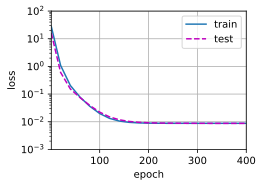

In [6]:
train(poly_features[:n_train, :4], # [:n_train]：选取前n_train个样本（训练集，100个）；[:4]：选取前4列特征
      poly_features[n_train:, :4], # [n_train:]  ：选取n_train之后的样本（测试集，100个）；
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.6632535 4.508657 ]]


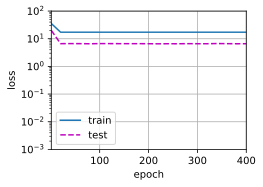

In [7]:
train(poly_features[:n_train, :2], # [:n_train]：选取前100个训练样本；[:2]：仅选取前2列特征
      poly_features[n_train:, :2], # [n_train:]：选取后100个测试样本
      labels[:n_train], labels[n_train:]) # 前100个和后100个样本的真实标签

高阶多项式函数拟合(过拟合)

weight: [[ 5.0284920e+00  1.2812659e+00 -3.4456682e+00  5.2318244e+00
   8.3101891e-02  9.6138966e-01  2.0295855e-01 -1.2872563e-01
   8.1015289e-02 -1.1810515e-01 -3.4315251e-02 -3.7153188e-02
  -2.2209860e-02  1.3247049e-01 -8.8749632e-02 -1.8632475e-01
  -4.3486722e-02 -3.6071013e-03  4.9656659e-02 -2.3428127e-02]]


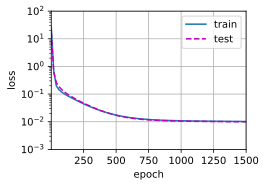

In [8]:
train(poly_features[:n_train, :], # [:n_train]：前100个训练样本；[:]：使用全部20列特征
      poly_features[n_train:, :], # [n_train:]：后100个测试样本
      labels[:n_train], labels[n_train:], num_epochs=1500) # 前100个训练标签和后100个测试标签